/tmp/ipykernel_288935/412377458.py:105: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


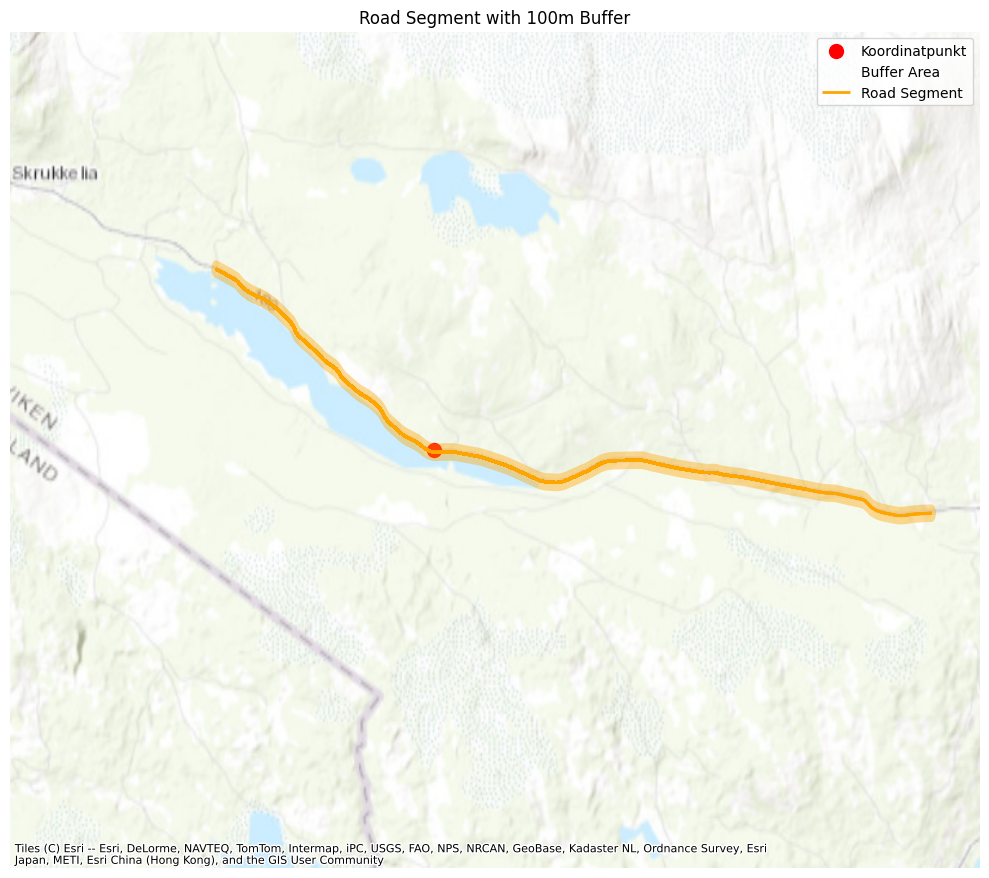

In [6]:
import osmnx as ox
import networkx as nx
from shapely import MultiLineString
from shapely.geometry import LineString, Polygon
from shapely.ops import unary_union, nearest_points
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import math
from geopy.distance import geodesic

lat, lon = 60.421797, 10.914340

ROAD_LENGTH_METER = 4375

def meters_to_degrees(meters):
    """
    Convert distance in meters to degrees for latitude and longitude. Roughly, close enough.
    """
    # Conversion for latitude (1 degree latitude ~ 111,320 meters)
    lat_degrees = meters / 111320

    # Conversion for longitude depends on the latitude (1 degree longitude varies)
    lon_degrees = meters / (111320 * math.cos(math.radians(lat)))
    
    return lat_degrees, lon_degrees

def get_road_characteristics(map):
    return {
        'highway': map.get('highway', 'unknown'),
        'lanes': map.get('lanes', 'unknown'),
        'maxspeed': map.get('maxspeed', 'unknown'),
        'name': map.get('name', 'unknown'),
        'oneway': map.get('oneway', 'unknown'),
    }

def get_graph_within_distance(G, lat, lon, max_distance_meters):
    """
    Get a subgraph containing only the edges within a specified distance from a point (lat, lon).

    Args:
        G: The graph representing the road network.
        lat, lon: Coordinates of the point (latitude, longitude).
        max_distance_meters: The maximum distance to search for edges in meters.

    Returns:
        A subgraph containing only the edges within the max distance from the point.
    """
    point = Point(lon, lat)
    nearest_edge = ox.distance.nearest_edges(G, X=lon, Y=lat)
    u, v, key = nearest_edge
    road_characteristics = get_road_characteristics(G[u][v][key])
    edges_within_distance = []
    for u, v, key in G.edges(keys=True):
        cur_road_characteristics = get_road_characteristics(G[u][v][key])
        geometry = G[u][v][key].get("geometry", None)
        distance_from_point = point.distance(geometry) if geometry else math.inf
        if cur_road_characteristics == road_characteristics and distance_from_point <= max_distance_meters:
            edges_within_distance.append((u, v, key))

    return G.edge_subgraph(edges_within_distance).copy()

def filter_edges(road_segment):
    edges = ox.graph_to_gdfs(road_segment, nodes=False)
    filtered_edges = []
    for idx, row in edges.iterrows():
        road_geometry = row['geometry']
        if road_geometry is not None:
            for geom in road_geometry.geoms if isinstance(road_geometry, MultiLineString) else [road_geometry]:
                for coord in geom.coords:
                    road_point = Point(coord[0], coord[1])
                    distance = geodesic((lat, lon), (road_point.y, road_point.x)).meters
                    if distance <= ROAD_LENGTH_METER:
                        filtered_edges.append(row)

    return gpd.GeoDataFrame(filtered_edges, crs=edges.crs)

lat_buf, lon_buf = meters_to_degrees(ROAD_LENGTH_METER)

G = ox.graph_from_point((lat, lon), dist=10000, network_type="drive")
road_segment = get_graph_within_distance(G, lat, lon, lon_buf)

# veg
edges = filter_edges(road_segment)

# punkt
coord_point_gpd = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=edges.crs)

# buffer
road_lines = unary_union(edges["geometry"])
buffered_polygon = road_lines.buffer(meters_to_degrees(50)[1])
buffer_gdf = gpd.GeoDataFrame(geometry=[buffered_polygon], crs=edges.crs)
# søkeområde
scirmish = gpd.GeoDataFrame(geometry=[Point(lon - lon_buf, lat - lat_buf), Point(lon - lon_buf, lat + lat_buf), Point(lon + lon_buf, lat - lat_buf), Point(lon + lon_buf, lat + lat_buf)], crs=edges.crs)

fig, ax = plt.subplots(figsize=(10, 10))
coord_point_gpd.plot(ax=ax, marker="o", color="red", markersize=100, label="Koordinatpunkt")
scirmish.plot(ax=ax, color="green", alpha=0, label="Buffer Area")
edges.plot(ax=ax, color="orange", linewidth=2, label="Road Segment")
buffer_gdf.plot(ax=ax, color="orange", alpha=0.4, label="100m Buffer")
cx.add_basemap(ax, source=cx.providers.Esri.WorldTopoMap, crs=edges.crs)
ax.set_axis_off()
plt.title("Road Segment with 100m Buffer")
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
print(buffered_polygon.contains(Point(11.447131, 60.625219)))

True
